# Embeddings with Continuous Bag of Words (CBOW)

Adapted from Natural Language Processing with Probabilistic Models<br/>
https://www.coursera.org/learn/probabilistic-models-in-nlp?specialization=natural-language-processing

Based on the context words, we'll try to predict the target/center word.

First we need to select a context half-size, $C$, and the dimensions of our vectors $N$.

For this example, we'll set $C=2$ and $N=50$.

So, for example, given the following sentence:
> Asian exporters fear damage from US Japan rift

our first target word is "fear" and the context words are ["asian", "exporters", "dmaage", "from"].

That is, we want to build a neural network that predicts "fear" from the context words.

See the [slides for the architecutre of the network](https://docs.google.com/presentation/d/1iMjzq7FGicGoTQ4ukFxAOWuSgFZBSAspaX1WvrWP8w8/edit#slide=id.g32c6a5713fb_0_297). 

The equations we need are:

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
 \hat y &= softmax(z)   \tag{4} \\
\end{align}


In [3]:
# Import Python libraries and helper functions (in utils2) 
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter
from utils2 import get_batches, compute_pca

from nltk.corpus import reuters

nltk.download('punkt')
nltk.download('reuters')

[nltk_data] Downloading package punkt to /Users/sydeis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package reuters to /Users/sydeis/nltk_data...


True

In [4]:
# Load, tokenize and process the data
import re                                                           #  Load the Regex-modul
data = []
for s in reuters.sents():
    data += s
data = "<SEP>".join(data)
data = re.sub(r'[,!?;-] ', '. ',data) #  Replace punctuation-space with .-space
data = data.replace('U<SEP>.<SEP>S<SEP>.', 'USA') #  Replace U.S. with USA
data = data.split("<SEP>")
#  Lower case and drop non-alphabetical tokens, strip space, -, and ,
data = [ ch.strip("-, ").lower() for ch in data if ch.strip("-, ").isalpha() or ch == '.']
print("Number of tokens:", len(data),'\n', data[:15])               #  print data sample




Number of tokens: 1405157 
 ['asian', 'exporters', 'fear', 'damage', 'from', 'usa', 'japan', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'usa', 'and']


In [5]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.

Size of vocabulary:  29174
Most frequent tokens:  [('.', 83729), ('the', 69277), ('of', 36779), ('to', 36400), ('in', 29253), ('and', 25648), ('said', 25383), ('a', 25103), ('mln', 18623), ('vs', 14341), ('for', 13782), ('dlrs', 12417), ('it', 11104), ('s', 10026), ('pct', 9810), ('on', 9244), ('lt', 8696), ('cts', 8361), ('from', 8217), ('is', 7668)]


#### Mapping words to indices and indices to words
We provide a helper function to create a dictionary that maps words to indices and indices to words.

In [6]:
def sigmoid(z):
    return 1 / (1 + math.exp(-z))

In [7]:
def get_dict(data):
    words = sorted(list(set(data)))  # Get unique words and sort them

    idx = 0

    word2Ind = {}  # Dictionary where keys are words and values are indices
    Ind2word = {}  # Dictionary where keys are indices and values are words
    
    # Create both mappings
    for k in words:
        word2Ind[k] = idx  # Map word to index
        Ind2word[idx] = k  # Map index to word
        idx += 1
    
    return word2Ind, Ind2word


In [8]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  29174


In [9]:
# example of word to index mapping
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Word with index 14234:  ",Ind2word[14234] )

Index of the word 'king' :   14234
Word with index 14234:   king


## Training the Model

### Initializing the Model

You will now initialize two matrices and two vectors. 
- The first matrix ($W_1$) is of dimension $N \times V$, where $V$ is the number of words in your vocabulary and $N$ is the dimension of your word vector.
- The second matrix ($W_2$) is of dimension $V \times N$. 
- Vector $b_1$ has dimensions $N\times 1$
- Vector $b_2$ has dimensions  $V\times 1$. 
- $b_1$ and $b_2$ are the bias vectors of the linear layers from matrices $W_1$ and $W_2$.

The overall structure of the model will look as in Figure 1, but at this stage we are just initializing the parameters. 

In [71]:
def initialize_model(N, V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
    Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    
    np.random.seed(random_seed) # DO NOT EDIT
    
    # Initialize all matrices with np.random.rand

    # W1 has shape (N,V)
    W1 = np.random.rand(N, V)
    
    # W2 has shape (V,N)
    W2 = np.random.rand(V, N)
    
    # b1 has shape (N,1)
    b1 = np.random.rand(N, 1)
    
    # b2 has shape (V,1)
    b2 = np.random.rand(V, 1)
    
    return W1, W2, b1, b2


In [72]:
# Test your function example.
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


##### Expected Output 

```CPP
tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)
```

### Softmax
Implement the softmax function as:  

$$ 
\text{softmax}(z_i) = \frac{e^{z_i} }{\sum_{i=0}^{V-1} e^{z_i} }
$$

In [73]:
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer. This is a 2D array, where each column represents one data point.
    Outputs: 
        yhat: prediction (estimate of y). 1D array
    '''
    # Step 1: Exponentiate each element of z
    exp_z = np.exp(z)
    
    # Step 2: Sum the exponentiated values for each column (along axis 0 for columns)
    sum_exp_z = np.sum(exp_z, axis=0, keepdims=True)
    
    # Step 3: Normalize by dividing each exponentiated value by the sum for its column
    yhat = exp_z / sum_exp_z
    
    # Since yhat is a 2D array, we return the column values as predictions for each data point
    return yhat


In [74]:
# Test the function
tmp = np.array([[1,2,3],
                [1,1,1]
               ])
tmp_sm = softmax(tmp)
display(tmp_sm)

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

##### Expected Ouput

```CPP
array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])
```

### Forward Propagation

Implement the forward propagation $z$ according to these equations:

\begin{align}
 h &= W_1 \  X + b_1\\
 h &= ReLU(h)\\
 z &= W_2 \  h + b_2\\
\end{align}

Use `np.maximum` to implement the Rectified Linear Unit (ReLU)

In [75]:
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    
    # Step 1: Calculate h (hidden layer pre-activation)
    h = np.dot(W1, x) + b1  # Linear transformation for hidden layer

    # Step 2: Apply ReLU on h, and store the result in h
    h = np.maximum(0, h)  # ReLU activation

    # Step 3: Calculate z (output score)
    z = np.dot(W2, h) + b2  # Linear transformation for output layer

    return z, h


In [76]:
# Test the function

# Create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T
#print(tmp_x)
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# Look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


##### Expected output
```CPP
x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]
```

### Cost Function

In [77]:
def compute_cost(y, yhat, batch_size):
    epsilon = 1e-8  # small value to avoid log(0)
    
    # Clip yhat to avoid log(0) or very small values
    yhat = np.clip(yhat, epsilon, 1 - epsilon)
    
    # Compute log-probabilities
    logprobs = np.multiply(np.log(yhat), y)
    
    # Compute cost
    cost = -1 / batch_size * np.sum(logprobs)
    
    # Squeeze the cost to make it a scalar if needed
    cost = np.squeeze(cost)
    
    return cost


In [78]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))
        
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (29174, 4)
tmp_y.shape (29174, 4)
tmp_W1.shape (50, 29174)
tmp_W2.shape (29174, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (29174, 1)
tmp_z.shape: (29174, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (29174, 4)
call compute_cost
tmp_cost 12.1551


##### Expected output

```CPP
tmp_x.shape (29174, 4)
tmp_y.shape (29174, 4)
tmp_W1.shape (50, 29174)
tmp_W2.shape (29174, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (29174, 1)
tmp_z.shape: (29174, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (29174, 4)
call compute_cost
tmp_cost 12.1551
```

### Training the Model - Backpropagation

Now that you have understood how the CBOW model works, you will train it. <br>
You created a function for the forward propagation. Now you will implement a function that computes the gradients to backpropagate the errors.

**Note**: `z1` is calculated as `W1⋅x + b1` in this function. In practice, you would save it already when making forward propagation and just re-use here, but for simplicity, it is calculated again in `back_prop`.

\begin{align}

\frac{\partial J_{batch}}{\partial W_1} &= \frac{1}{m}(W_2^T(\hat{Y}-Y) \cdot step(Z_1))X^T \\

\frac{\partial J_{batch}}{\partial W_2} &= \frac{1}{m}(\hat{Y}-Y)H^T\\

\frac{\partial J_{batch}}{\partial b_1} &= \frac{1}{m}(W_2^T(\hat{Y}-Y) \cdot step(Z_1))1_m^T \\

\frac{\partial J_{batch}}{\partial b_2} &= \frac{1}{m}(\hat{Y}-Y)1_m^T\\

\end{align}

Note that $1_m$ is a $(1 \times m)$ matrix of all ones. Transposed, $1_m^T$ is a $m$-row, one-column matrix of all ones. <br/>
In practice, you should use `np.sum(x, axis=1, keepdims=True)` and not matrix multiplication by $1_m^T$

In [79]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    
    # Compute z1
    z1 = np.dot(W1, x) + b1
    
    # Compute l1 as W2^T (Ŷ - Y)
    l1 = np.dot(W2.T, (yhat - y))

    # Apply ReLU derivative
    l1[z1 < 0] = 0  

    # Compute gradients
    grad_W1 = np.dot(l1, x.T) / batch_size
    grad_W2 = np.dot(yhat - y, h.T) / batch_size
    grad_b1 = np.sum(l1, axis=1, keepdims=True) / batch_size
    grad_b2 = np.sum(yhat - y, axis=1, keepdims=True) / batch_size
    
    return grad_W1, grad_W2, grad_b1, grad_b2


In [80]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)


# get a batch of data
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (29174, 4)
tmp_y.shape (29174, 4)

Initialize weights and biases
tmp_W1.shape (50, 29174)
tmp_W2.shape (29174, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (29174, 1)

Forwad prop to get z and h
tmp_z.shape: (29174, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (29174, 4)

call back_prop
tmp_grad_W1.shape (50, 29174)
tmp_grad_W2.shape (29174, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (29174, 1)


##### Expected output

```CPP
get a batch of data
tmp_x.shape (29174, 4)
tmp_y.shape (29174, 4)

Initialize weights and biases
tmp_W1.shape (50, 29174)
tmp_W2.shape (29174, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (29174, 1)

Forwad prop to get z and h
tmp_z.shape: (29174, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (29174, 4)

call back_prop
tmp_grad_W1.shape (50, 29174)
tmp_grad_W2.shape (29174, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (29174, 1)
```

In [81]:
# Now you can print the mean of gradients
print(f"grad_W1 mean: {np.mean(tmp_grad_W1)}, grad_W2 mean: {np.mean(tmp_grad_W2)}")


grad_W1 mean: 2.5241332119820953e-06, grad_W2 mean: -3.009573387711322e-20


### Gradient Descent

Now that you have implemented a function to compute the gradients, you will implement batch gradient descent over your training set. 

**Hint:** For that, you will use `initialize_model` and the `back_prop` functions which you just created (and the `compute_cost` function). You can also use the provided `get_batches` helper function:

```for x, y in get_batches(data, word2Ind, V, C, batch_size):```

Also: print the cost after each batch is processed

In [94]:
def gradient_descent(data, word2Ind, N, V, num_iters, batch_size=128, alpha=0.8, 
                     random_seed=1, initialize_model=initialize_model, 
                     get_batches=get_batches, forward_prop=forward_prop, 
                     softmax=softmax, compute_cost=compute_cost, 
                     back_prop=back_prop):
    '''
    This is the gradient_descent function

    Inputs: 
      data:      text
      word2Ind:  words to Indices
      N:         dimension of hidden vector  
      V:         dimension of vocabulary 
      num_iters: number of iterations  
      random_seed: random seed to initialize the model's matrices and vectors
      initialize_model: your implementation of the function to initialize the model
      get_batches: function to get the data in batches
      forward_prop: your implementation of the function to perform forward propagation
      softmax: your implementation of the softmax function
      compute_cost: cost function (Cross entropy)
      back_prop: your implementation of the function to perform backward propagation

    Outputs: 
      W1, W2, b1, b2:  updated matrices and biases after num_iters iterations
    '''
    # Initialize weights and biases
    W1, W2, b1, b2 = initialize_model(N, V, random_seed=random_seed)  # W1=(N,V) and W2=(V,N)

    iters = 0
    C = 2  # Number of classes (adjust if needed)

    # Loop over batches of data
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        # Forward propagation: compute z (scores) and h (hidden layer)
        z, h = forward_prop(x, W1, W2, b1, b2)

        # Apply softmax to get predictions (yhat)
        yhat = softmax(z)

        # Compute the cost (cross-entropy loss) for the batch
        cost = compute_cost(yhat, y, batch_size)

        # Print cost every 25 iterations
        if (iters + 1) % 25 == 0:
            print(f"iters: {iters + 1} cost: {cost:.6f}") # Backpropagation: compute gradients for W1, W2, b1, b2
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)

        # Update weights and biases using gradient descent
        W1 -= alpha * grad_W1
        W2 -= alpha * grad_W2
        b1 -= alpha * grad_b1
        b2 -= alpha * grad_b2

        # Increment the iteration count
        iters += 1

        # Break if we've completed the desired number of iterations
        if iters == num_iters:
            break

        # Reduce the learning rate every 100 iterations
        if iters % 100 == 0:
            alpha *= 0.66

    print("Returning W1, W2, b1, b2...")
    return W1, W2, b1, b2



In [95]:
print(f"W1 initialized: {W1}")
print(f"W2 initialized: {W2}")

W1 initialized: [[0.18512975 0.89535801 0.73199394 ... 0.46433044 0.55500247 0.80185241]
 [0.20521841 0.31191228 0.13008157 ... 0.02310409 0.9446748  0.08792926]
 [0.64086929 0.68873827 0.74873469 ... 0.74776267 0.74002153 0.85032287]
 ...
 [0.61215231 0.37297361 0.05294879 ... 0.02197238 0.90580225 0.28987329]
 [0.1877249  0.0805076  0.05155922 ... 0.46025709 0.25733221 0.38073412]
 [0.29427675 0.72732766 0.86600917 ... 0.04399944 0.81357008 0.29865785]]
W2 initialized: [[0.95388864 0.97013622 0.63384013 ... 1.17903803 1.04370987 1.2461703 ]
 [0.63820635 1.29354634 1.07559615 ... 1.14841623 0.45824729 0.84466322]
 [0.37250371 0.90014827 0.96338861 ... 0.12844487 0.83896584 0.25118623]
 ...
 [0.65177208 0.77039533 0.91833465 ... 0.84385016 0.98696766 0.21912419]
 [0.24962956 0.7820664  0.36976964 ... 0.52261014 0.20107438 0.7213464 ]
 [0.46209515 0.29503633 0.62991581 ... 0.37763137 0.45135341 0.56321567]]


In [96]:
# test your function

C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 250
batch_size = 128
print("Calling gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters, batch_size, alpha=0.5)

Calling gradient_descent
iters: 25 cost: 18.419660
iters: 50 cost: 18.356683
iters: 75 cost: 18.308140
iters: 100 cost: 18.268198
iters: 125 cost: 18.220679
iters: 150 cost: 18.281706
iters: 175 cost: 18.192450
iters: 200 cost: 18.297904
iters: 225 cost: 18.242320
iters: 250 cost: 18.271313
Returning W1, W2, b1, b2...


##### Expected Output

```python
Calling gradient_descent
iters: 25 cost: 9.240195
iters: 50 cost: 8.967856
iters: 75 cost: 8.452854
iters: 100 cost: 8.664515
iters: 125 cost: 8.083584
iters: 150 cost: 8.814797
iters: 175 cost: 8.064355
iters: 200 cost: 8.471108
iters: 225 cost: 8.155348
iters: 250 cost: 8.257302
```        
        
Your numbers may differ somewhat depending on package and Python versions.

# Compute embeddings



In [98]:
embedding_matrix = (W1.T + W2) / 2  # Averaging the transposes of W1 and W2

# Check the shape of the embedding matrix
print(embedding_matrix.shape)  # Expected shape: (29174, 50)

# Compute the L2 norm for each row in the embedding matrix
row_norm = np.linalg.norm(embedding_matrix, axis=1)
print(row_norm[0:5])  # Print the first 5 row norms

# Verify the row norms are correct
assert np.all(row_norm == np.linalg.norm(embedding_matrix, axis=1)), "Check your code"

# Now divide each element of the embedding matrix by its corresponding row norm to normalize
l2_embeddings = embedding_matrix / row_norm[:, np.newaxis]

# Print the shape of the normalized embeddings
print(l2_embeddings.shape)  # Should also be (29174, 50)

# Check the sum of each row in the normalized embedding matrix
print(l2_embeddings.sum(axis=1)[0:5])  # Sum for the first 5 rows should be 1 (due to normalization)

# Check the sum of each row in the original embedding matrix before normalization
print(embedding_matrix.sum(axis=1)[0:5])  # Sum for the first 5 rows in the original matrix


(29174, 50)
[1.00165035 0.93153275 0.7363197  0.66869576 0.59063116]
(29174, 50)
[ 3.90215512  3.48807634  1.52794241 -1.167805   -0.60655154]
[ 3.90859505  3.24925735  1.12505409 -0.78090626 -0.35824824]


# Cosine similarity

$$
cos(\vec{v}, \vec{w}) = \frac{\vec{v}\cdot\vec{w}}{\|v\| \|w\|} = \frac{\vec{v}}{\|v\|}\cdot\frac{\vec{w}}{\|w\|} = \frac{\sum_{i=1}^{N}{v_iw_i}}{\sqrt{\sum_{i=1}^N{v_i^2}}\sqrt{\sum_{i=1}^N{w_i^2}}}
$$

# Cosine distance? 

$$
dist(\vec{v}, \vec{w}) = 1- cos(\vec{v}, \vec{w})
$$


In [107]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similarity between u and v.
    
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)
    
    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula.
    """
    # Compute the dot product between u and v
    dot = np.dot(u, v)
    
    # Compute the L2 norm of u and v
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)

    # Compute the cosine similarity defined by the formula above
    cosine_similarity = dot / (norm_u * norm_v)

    return cosine_similarity



In [108]:
# Check the cosine_similarity function
e1 = embedding_matrix[word2Ind['queen'],:]
e2 = embedding_matrix[word2Ind['king'],:]
result = cosine_similarity(e1,e2)
print(result)

import scipy.spatial.distance
expected_result = 1-scipy.spatial.distance.cosine(e1,e2)

if f"{result:.04f}" != f"{expected_result:.04f}":
    print("Error")
else:
    print("Great work")


-0.06644255492874718
Great work


In [116]:
def most_similar_words(word, l2_embeddings, word2Ind, Ind2word, k=10):
    """
    Find the k most similar words to a given word
        word - a word, as a string
        l2_embeddings - a matrix where the ith row represents the embedding of the ith word
          **NB l2_embeddings is l2 normalized**
        word2Ind - a dictionary where the keys are words and the value is the corresponding index
        Ind2word - a dictionary where the keys are indices and the value is the corresponding word
        k - number of similar words to retrieve
    Returns:
        similar_words - a list of the k most similar words and their cosine similarities
    """
    # Find the index of the word and store in idx
    idx = word2Ind[word]

    # Get the embedding at idx and store in word_embedding
    word_embedding = l2_embeddings[idx]
    
    # Get the similarity of word_embedding to all other embeddings in l2_embeddings
    # We do this by multiplying l2_embeddings and word_embedding using dot product
    sims = np.dot(l2_embeddings, word_embedding)  # Cosine similarity is the dot product for normalized vectors

    # Build a list of lists where each sublist is of the form [word, similarity]
    word_sims = [[Ind2word[i], float(sims[i])] for i in range(len(sims))]
    
    # Sort the list of words by similarity in descending order
    word_sims.sort(key=lambda x: x[1], reverse=True)

    for word, similarity in word_sims[:10]:
        print(f"{word}: {similarity}")

    # Return the top k words and their similarities
    return word_sims[:k]

# Example usage:
most_similar_words('king', l2_embeddings, word2Ind, Ind2word, k=3)


king: 1.0
asarco: 0.5363081450380045
leucadia: 0.5236445996037522
effectiveness: 0.5205254154050892
burr: 0.5204637358803581
daan: 0.49759604772530613
defiant: 0.49075000027659765
highlands: 0.48845053339568945
hiring: 0.4782637543725018
invoice: 0.4769294314850542


[['king', 1.0],
 ['asarco', 0.5363081450380045],
 ['leucadia', 0.5236445996037522]]

In [110]:
print(np.linalg.norm(l2_embeddings, axis=1)[0:5])  # Check if each row has a norm of 1

[1. 1. 1. 1. 1.]


In [111]:
print(word2Ind['king'])  # Should give you the index of 'king'
print(Ind2word[word2Ind['king']])  # Should give you 'king'

14234
king


In [113]:
print(word2Ind['king'])  # Check the index of 'king'
print(Ind2word[word2Ind['king']])  # Check the word corresponding to that index

14234
king


In [112]:
print(l2_embeddings[word2Ind['king']])  # Check 'king' embedding
print(l2_embeddings[word2Ind['queen']])  # Check 'queen' embedding

[ 0.23567503 -0.0566967  -0.17935227 -0.03207688  0.07952088  0.17980117
 -0.22266365  0.07540515  0.01082118  0.18889958 -0.01523545 -0.12501612
  0.16862589  0.14832261  0.08323041 -0.2517782   0.03178462  0.00467873
  0.02546307  0.10336333 -0.00676892  0.12400807 -0.21202041  0.05449152
  0.00470659 -0.07083521 -0.14662569  0.04351192  0.02476593 -0.08772843
  0.20744647 -0.16308505 -0.12206933  0.09230743 -0.11579892  0.06157685
  0.24752095  0.13907897 -0.23004548 -0.07960041 -0.27621896  0.13820001
 -0.04084241  0.15792369  0.17708243 -0.25771594 -0.17367743 -0.11512291
  0.03434797 -0.12151281]
[ 0.12278229  0.13784842  0.02388702  0.153475    0.18598148  0.1560833
  0.11564202  0.05724336 -0.20953706  0.07561126  0.32803943 -0.21121619
  0.05542756  0.15249784 -0.18786768  0.14088365 -0.07832707  0.12816816
 -0.01684586 -0.11841019 -0.07842105 -0.06367003 -0.10648829 -0.10233931
  0.06361695  0.21410466 -0.12473437 -0.11096909  0.13460007  0.01665161
 -0.08604276 -0.17944316  

Expected output
```python
[['king', 1.0],
 ['expert', 0.9564565557735208],
 ['astrotech', 0.9522382080696267]]
```

## Visualizing the Word Vectors


In [117]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','men', 'dog','wolf', 'women',
         'rich','happy','sad', 'japan', 'tokyo', 'washington', 'us']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(14, 50) [14234, 20762, 15271, 16163, 7688, 28776, 28784, 22202, 11611, 22688, 13727, 26466, 28259, 27610]


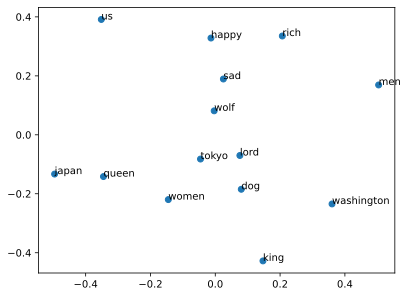

In [118]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

However, we have to be careful with the interpretation of this projected word vectors, since the PCA depends on the projection

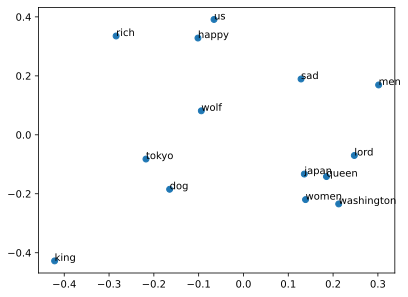

In [119]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()